# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:06<00:00, 9.61KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

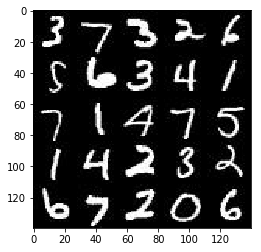

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

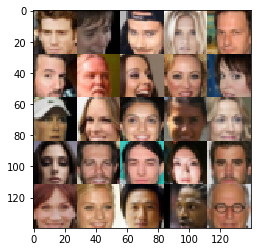

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/debadyuti/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 4.9540... Generator Loss: 15.8335
Epoch 1/2... Batch 20... Discriminator Loss: 0.4750... Generator Loss: 4.6585
Epoch 1/2... Batch 30... Discriminator Loss: 2.1785... Generator Loss: 12.4404
Epoch 1/2... Batch 40... Discriminator Loss: 0.5442... Generator Loss: 2.6982
Epoch 1/2... Batch 50... Discriminator Loss: 2.2717... Generator Loss: 0.2453
Epoch 1/2... Batch 60... Discriminator Loss: 0.5849... Generator Loss: 2.2229
Epoch 1/2... Batch 70... Discriminator Loss: 0.8706... Generator Loss: 2.8924
Epoch 1/2... Batch 80... Discriminator Loss: 1.8814... Generator Loss: 0.4359
Epoch 1/2... Batch 90... Discriminator Loss: 1.4237... Generator Loss: 0.6905
Epoch 1/2... Batch 100... Discriminator Loss: 2.2618... Generator Loss: 0.2216


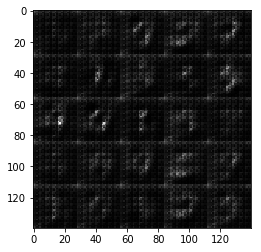

Epoch 1/2... Batch 110... Discriminator Loss: 1.0413... Generator Loss: 1.0565
Epoch 1/2... Batch 120... Discriminator Loss: 1.3602... Generator Loss: 0.7027
Epoch 1/2... Batch 130... Discriminator Loss: 1.0922... Generator Loss: 1.1434
Epoch 1/2... Batch 140... Discriminator Loss: 1.5079... Generator Loss: 2.3208
Epoch 1/2... Batch 150... Discriminator Loss: 1.2416... Generator Loss: 0.7953
Epoch 1/2... Batch 160... Discriminator Loss: 1.2462... Generator Loss: 2.1802
Epoch 1/2... Batch 170... Discriminator Loss: 1.1881... Generator Loss: 0.8358
Epoch 1/2... Batch 180... Discriminator Loss: 2.1517... Generator Loss: 0.2190
Epoch 1/2... Batch 190... Discriminator Loss: 1.1237... Generator Loss: 0.9394
Epoch 1/2... Batch 200... Discriminator Loss: 1.7450... Generator Loss: 0.3407


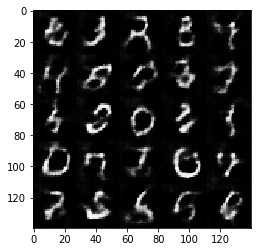

Epoch 1/2... Batch 210... Discriminator Loss: 1.2146... Generator Loss: 1.0806
Epoch 1/2... Batch 220... Discriminator Loss: 1.6585... Generator Loss: 0.3779
Epoch 1/2... Batch 230... Discriminator Loss: 1.3130... Generator Loss: 1.4566
Epoch 1/2... Batch 240... Discriminator Loss: 1.2718... Generator Loss: 0.6966
Epoch 1/2... Batch 250... Discriminator Loss: 1.0776... Generator Loss: 1.1485
Epoch 1/2... Batch 260... Discriminator Loss: 1.2065... Generator Loss: 0.9649
Epoch 1/2... Batch 270... Discriminator Loss: 1.8565... Generator Loss: 0.2870
Epoch 1/2... Batch 280... Discriminator Loss: 1.2173... Generator Loss: 0.7056
Epoch 1/2... Batch 290... Discriminator Loss: 1.3557... Generator Loss: 0.5684
Epoch 1/2... Batch 300... Discriminator Loss: 1.1385... Generator Loss: 1.0913


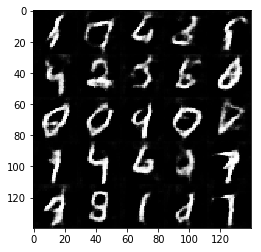

Epoch 1/2... Batch 310... Discriminator Loss: 1.1381... Generator Loss: 0.9332
Epoch 1/2... Batch 320... Discriminator Loss: 1.1823... Generator Loss: 1.8204
Epoch 1/2... Batch 330... Discriminator Loss: 1.2599... Generator Loss: 0.6813
Epoch 1/2... Batch 340... Discriminator Loss: 1.2030... Generator Loss: 0.8771
Epoch 1/2... Batch 350... Discriminator Loss: 1.1667... Generator Loss: 1.3374
Epoch 1/2... Batch 360... Discriminator Loss: 1.1838... Generator Loss: 0.7770
Epoch 1/2... Batch 370... Discriminator Loss: 1.1905... Generator Loss: 0.9119
Epoch 1/2... Batch 380... Discriminator Loss: 1.1269... Generator Loss: 0.9149
Epoch 1/2... Batch 390... Discriminator Loss: 1.1992... Generator Loss: 1.4716
Epoch 1/2... Batch 400... Discriminator Loss: 1.4354... Generator Loss: 0.4968


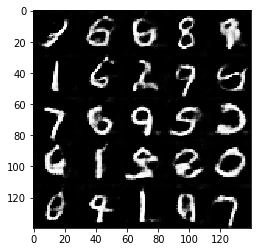

Epoch 1/2... Batch 410... Discriminator Loss: 1.2730... Generator Loss: 1.2538
Epoch 1/2... Batch 420... Discriminator Loss: 1.1707... Generator Loss: 1.0093
Epoch 1/2... Batch 430... Discriminator Loss: 1.2626... Generator Loss: 0.6797
Epoch 1/2... Batch 440... Discriminator Loss: 1.1726... Generator Loss: 0.7318
Epoch 1/2... Batch 450... Discriminator Loss: 2.7001... Generator Loss: 3.4769
Epoch 1/2... Batch 460... Discriminator Loss: 1.1683... Generator Loss: 0.9892
Epoch 2/2... Batch 10... Discriminator Loss: 1.1437... Generator Loss: 0.8953
Epoch 2/2... Batch 20... Discriminator Loss: 1.2702... Generator Loss: 0.6608
Epoch 2/2... Batch 30... Discriminator Loss: 1.3848... Generator Loss: 0.5350
Epoch 2/2... Batch 40... Discriminator Loss: 1.2343... Generator Loss: 0.7342
Epoch 2/2... Batch 50... Discriminator Loss: 1.1255... Generator Loss: 0.9241
Epoch 2/2... Batch 60... Discriminator Loss: 1.1013... Generator Loss: 0.9079
Epoch 2/2... Batch 70... Discriminator Loss: 1.3265... Gen

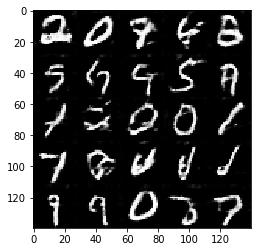

Epoch 2/2... Batch 110... Discriminator Loss: 1.1670... Generator Loss: 0.8702
Epoch 2/2... Batch 120... Discriminator Loss: 1.2363... Generator Loss: 1.0285
Epoch 2/2... Batch 130... Discriminator Loss: 1.1416... Generator Loss: 0.9951
Epoch 2/2... Batch 140... Discriminator Loss: 1.4474... Generator Loss: 0.4830
Epoch 2/2... Batch 150... Discriminator Loss: 1.3309... Generator Loss: 1.1294
Epoch 2/2... Batch 160... Discriminator Loss: 1.2308... Generator Loss: 0.8744
Epoch 2/2... Batch 170... Discriminator Loss: 1.4838... Generator Loss: 0.4763
Epoch 2/2... Batch 180... Discriminator Loss: 1.2126... Generator Loss: 0.8866
Epoch 2/2... Batch 190... Discriminator Loss: 1.2248... Generator Loss: 1.0778
Epoch 2/2... Batch 200... Discriminator Loss: 1.3751... Generator Loss: 0.5915


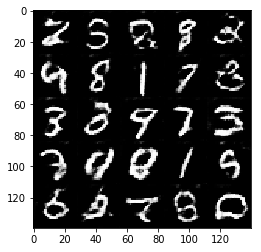

Epoch 2/2... Batch 210... Discriminator Loss: 1.2245... Generator Loss: 0.8606
Epoch 2/2... Batch 220... Discriminator Loss: 1.3062... Generator Loss: 0.6979
Epoch 2/2... Batch 230... Discriminator Loss: 1.5499... Generator Loss: 0.4638
Epoch 2/2... Batch 240... Discriminator Loss: 1.2269... Generator Loss: 0.9134
Epoch 2/2... Batch 250... Discriminator Loss: 1.1511... Generator Loss: 0.8829
Epoch 2/2... Batch 260... Discriminator Loss: 1.3020... Generator Loss: 0.6655
Epoch 2/2... Batch 270... Discriminator Loss: 1.3410... Generator Loss: 0.5538
Epoch 2/2... Batch 280... Discriminator Loss: 1.2833... Generator Loss: 0.6751
Epoch 2/2... Batch 290... Discriminator Loss: 1.3080... Generator Loss: 1.5007
Epoch 2/2... Batch 300... Discriminator Loss: 1.6586... Generator Loss: 2.4899


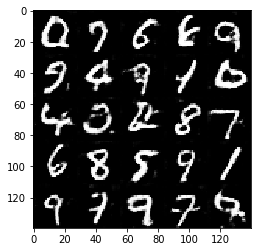

Epoch 2/2... Batch 310... Discriminator Loss: 1.2597... Generator Loss: 1.1420
Epoch 2/2... Batch 320... Discriminator Loss: 1.4248... Generator Loss: 0.5028
Epoch 2/2... Batch 330... Discriminator Loss: 1.0480... Generator Loss: 1.1434
Epoch 2/2... Batch 340... Discriminator Loss: 1.3223... Generator Loss: 0.6111
Epoch 2/2... Batch 350... Discriminator Loss: 1.3519... Generator Loss: 0.6182
Epoch 2/2... Batch 360... Discriminator Loss: 1.4298... Generator Loss: 0.5276
Epoch 2/2... Batch 370... Discriminator Loss: 1.4277... Generator Loss: 0.4942
Epoch 2/2... Batch 380... Discriminator Loss: 1.3111... Generator Loss: 1.5734
Epoch 2/2... Batch 390... Discriminator Loss: 1.2197... Generator Loss: 0.7032
Epoch 2/2... Batch 400... Discriminator Loss: 1.1409... Generator Loss: 1.0722


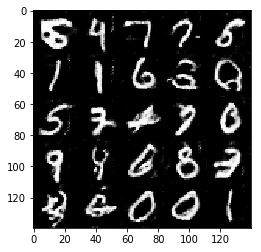

Epoch 2/2... Batch 410... Discriminator Loss: 1.3060... Generator Loss: 0.5644
Epoch 2/2... Batch 420... Discriminator Loss: 1.3446... Generator Loss: 0.5597
Epoch 2/2... Batch 430... Discriminator Loss: 1.1172... Generator Loss: 0.8260
Epoch 2/2... Batch 440... Discriminator Loss: 1.1303... Generator Loss: 1.4695
Epoch 2/2... Batch 450... Discriminator Loss: 1.2723... Generator Loss: 2.0918
Epoch 2/2... Batch 460... Discriminator Loss: 1.0748... Generator Loss: 0.9379


In [14]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.7085... Generator Loss: 9.9942
Epoch 1/1... Batch 20... Discriminator Loss: 0.5567... Generator Loss: 3.4168
Epoch 1/1... Batch 30... Discriminator Loss: 0.8361... Generator Loss: 1.8926
Epoch 1/1... Batch 40... Discriminator Loss: 0.9566... Generator Loss: 1.6792
Epoch 1/1... Batch 50... Discriminator Loss: 1.1420... Generator Loss: 0.7225
Epoch 1/1... Batch 60... Discriminator Loss: 0.9512... Generator Loss: 1.4746
Epoch 1/1... Batch 70... Discriminator Loss: 1.0056... Generator Loss: 1.4897
Epoch 1/1... Batch 80... Discriminator Loss: 1.4523... Generator Loss: 0.8507
Epoch 1/1... Batch 90... Discriminator Loss: 1.7569... Generator Loss: 0.5533
Epoch 1/1... Batch 100... Discriminator Loss: 1.0877... Generator Loss: 1.1443


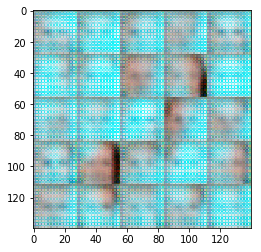

Epoch 1/1... Batch 110... Discriminator Loss: 1.3466... Generator Loss: 1.0013
Epoch 1/1... Batch 120... Discriminator Loss: 1.9849... Generator Loss: 1.4704
Epoch 1/1... Batch 130... Discriminator Loss: 0.9617... Generator Loss: 1.3488
Epoch 1/1... Batch 140... Discriminator Loss: 1.2696... Generator Loss: 0.9033
Epoch 1/1... Batch 150... Discriminator Loss: 1.5058... Generator Loss: 0.8315
Epoch 1/1... Batch 160... Discriminator Loss: 1.7290... Generator Loss: 0.7242
Epoch 1/1... Batch 170... Discriminator Loss: 1.3219... Generator Loss: 0.8011
Epoch 1/1... Batch 180... Discriminator Loss: 1.1932... Generator Loss: 0.8018
Epoch 1/1... Batch 190... Discriminator Loss: 1.3338... Generator Loss: 1.5596
Epoch 1/1... Batch 200... Discriminator Loss: 1.2265... Generator Loss: 1.1172


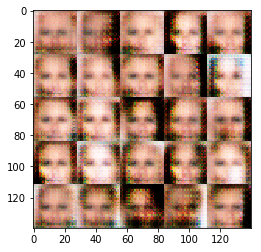

Epoch 1/1... Batch 210... Discriminator Loss: 0.9696... Generator Loss: 1.0862
Epoch 1/1... Batch 220... Discriminator Loss: 1.2449... Generator Loss: 0.9406
Epoch 1/1... Batch 230... Discriminator Loss: 0.9943... Generator Loss: 0.9291
Epoch 1/1... Batch 240... Discriminator Loss: 1.2425... Generator Loss: 0.8485
Epoch 1/1... Batch 250... Discriminator Loss: 0.5978... Generator Loss: 1.7028
Epoch 1/1... Batch 260... Discriminator Loss: 1.6922... Generator Loss: 1.8854
Epoch 1/1... Batch 270... Discriminator Loss: 3.1468... Generator Loss: 0.0968
Epoch 1/1... Batch 280... Discriminator Loss: 1.2141... Generator Loss: 0.9068
Epoch 1/1... Batch 290... Discriminator Loss: 1.0631... Generator Loss: 0.9294
Epoch 1/1... Batch 300... Discriminator Loss: 1.2377... Generator Loss: 1.1415


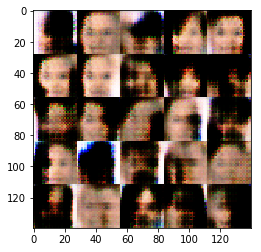

Epoch 1/1... Batch 310... Discriminator Loss: 1.1259... Generator Loss: 1.0657
Epoch 1/1... Batch 320... Discriminator Loss: 1.2284... Generator Loss: 0.6342
Epoch 1/1... Batch 330... Discriminator Loss: 0.9876... Generator Loss: 1.0885
Epoch 1/1... Batch 340... Discriminator Loss: 1.1093... Generator Loss: 0.8875
Epoch 1/1... Batch 350... Discriminator Loss: 0.6359... Generator Loss: 1.5140
Epoch 1/1... Batch 360... Discriminator Loss: 0.7929... Generator Loss: 1.4220
Epoch 1/1... Batch 370... Discriminator Loss: 0.8056... Generator Loss: 1.2000
Epoch 1/1... Batch 380... Discriminator Loss: 0.8055... Generator Loss: 1.6809
Epoch 1/1... Batch 390... Discriminator Loss: 0.9591... Generator Loss: 1.3394
Epoch 1/1... Batch 400... Discriminator Loss: 1.9300... Generator Loss: 2.6348


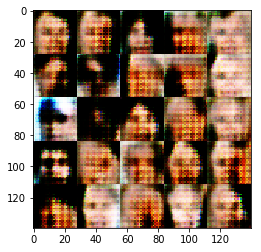

Epoch 1/1... Batch 410... Discriminator Loss: 1.0034... Generator Loss: 0.8940
Epoch 1/1... Batch 420... Discriminator Loss: 0.9665... Generator Loss: 1.3233
Epoch 1/1... Batch 430... Discriminator Loss: 1.1618... Generator Loss: 2.3892
Epoch 1/1... Batch 440... Discriminator Loss: 1.5388... Generator Loss: 1.9264
Epoch 1/1... Batch 450... Discriminator Loss: 1.4126... Generator Loss: 0.6684
Epoch 1/1... Batch 460... Discriminator Loss: 1.0968... Generator Loss: 1.2845
Epoch 1/1... Batch 470... Discriminator Loss: 0.9676... Generator Loss: 1.5199
Epoch 1/1... Batch 480... Discriminator Loss: 1.3018... Generator Loss: 0.5954
Epoch 1/1... Batch 490... Discriminator Loss: 1.2152... Generator Loss: 0.8942
Epoch 1/1... Batch 500... Discriminator Loss: 0.7751... Generator Loss: 1.3403


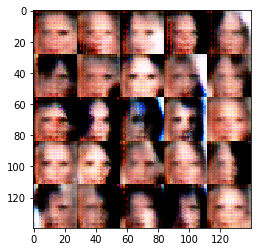

Epoch 1/1... Batch 510... Discriminator Loss: 1.2320... Generator Loss: 1.7497
Epoch 1/1... Batch 520... Discriminator Loss: 1.6641... Generator Loss: 0.5163
Epoch 1/1... Batch 530... Discriminator Loss: 0.5425... Generator Loss: 2.1002
Epoch 1/1... Batch 540... Discriminator Loss: 2.4016... Generator Loss: 0.3358
Epoch 1/1... Batch 550... Discriminator Loss: 1.5686... Generator Loss: 0.4911
Epoch 1/1... Batch 560... Discriminator Loss: 0.7300... Generator Loss: 1.2719
Epoch 1/1... Batch 570... Discriminator Loss: 0.9658... Generator Loss: 2.1272
Epoch 1/1... Batch 580... Discriminator Loss: 0.4194... Generator Loss: 3.5276
Epoch 1/1... Batch 590... Discriminator Loss: 0.7280... Generator Loss: 1.3323
Epoch 1/1... Batch 600... Discriminator Loss: 0.6878... Generator Loss: 2.3984


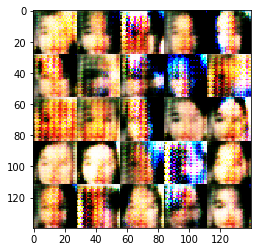

Epoch 1/1... Batch 610... Discriminator Loss: 0.7295... Generator Loss: 3.0653
Epoch 1/1... Batch 620... Discriminator Loss: 1.5849... Generator Loss: 0.4700
Epoch 1/1... Batch 630... Discriminator Loss: 0.8654... Generator Loss: 1.6415
Epoch 1/1... Batch 640... Discriminator Loss: 2.0618... Generator Loss: 4.1696
Epoch 1/1... Batch 650... Discriminator Loss: 0.7785... Generator Loss: 1.6254
Epoch 1/1... Batch 660... Discriminator Loss: 1.4579... Generator Loss: 0.5640
Epoch 1/1... Batch 670... Discriminator Loss: 1.1985... Generator Loss: 0.8297
Epoch 1/1... Batch 680... Discriminator Loss: 1.3588... Generator Loss: 0.5712
Epoch 1/1... Batch 690... Discriminator Loss: 1.1737... Generator Loss: 1.6796
Epoch 1/1... Batch 700... Discriminator Loss: 0.9068... Generator Loss: 1.4019


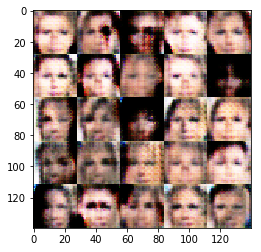

Epoch 1/1... Batch 710... Discriminator Loss: 0.7269... Generator Loss: 1.3621
Epoch 1/1... Batch 720... Discriminator Loss: 0.9547... Generator Loss: 1.2676
Epoch 1/1... Batch 730... Discriminator Loss: 1.1175... Generator Loss: 1.8211
Epoch 1/1... Batch 740... Discriminator Loss: 0.9705... Generator Loss: 1.1579
Epoch 1/1... Batch 750... Discriminator Loss: 2.2358... Generator Loss: 0.2424
Epoch 1/1... Batch 760... Discriminator Loss: 0.8448... Generator Loss: 1.2920
Epoch 1/1... Batch 770... Discriminator Loss: 1.0281... Generator Loss: 0.9196
Epoch 1/1... Batch 780... Discriminator Loss: 1.3163... Generator Loss: 0.7600
Epoch 1/1... Batch 790... Discriminator Loss: 1.2859... Generator Loss: 0.9291
Epoch 1/1... Batch 800... Discriminator Loss: 1.0384... Generator Loss: 1.0204


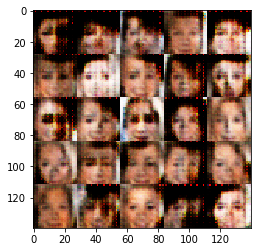

Epoch 1/1... Batch 810... Discriminator Loss: 2.2942... Generator Loss: 3.1403
Epoch 1/1... Batch 820... Discriminator Loss: 0.8414... Generator Loss: 1.1187
Epoch 1/1... Batch 830... Discriminator Loss: 0.5490... Generator Loss: 1.8317
Epoch 1/1... Batch 840... Discriminator Loss: 1.8673... Generator Loss: 0.4190
Epoch 1/1... Batch 850... Discriminator Loss: 0.8683... Generator Loss: 1.2084
Epoch 1/1... Batch 860... Discriminator Loss: 1.1321... Generator Loss: 1.2559
Epoch 1/1... Batch 870... Discriminator Loss: 0.9888... Generator Loss: 1.9776
Epoch 1/1... Batch 880... Discriminator Loss: 1.2095... Generator Loss: 0.9516
Epoch 1/1... Batch 890... Discriminator Loss: 0.8943... Generator Loss: 1.1465
Epoch 1/1... Batch 900... Discriminator Loss: 0.9278... Generator Loss: 2.7181


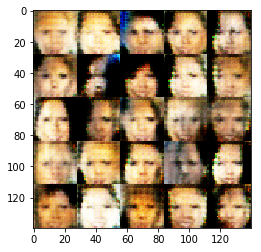

Epoch 1/1... Batch 910... Discriminator Loss: 0.6825... Generator Loss: 1.6156
Epoch 1/1... Batch 920... Discriminator Loss: 1.1119... Generator Loss: 0.7265
Epoch 1/1... Batch 930... Discriminator Loss: 0.9450... Generator Loss: 0.8938
Epoch 1/1... Batch 940... Discriminator Loss: 1.3871... Generator Loss: 0.6115
Epoch 1/1... Batch 950... Discriminator Loss: 1.0910... Generator Loss: 1.2461
Epoch 1/1... Batch 960... Discriminator Loss: 1.0119... Generator Loss: 0.8214
Epoch 1/1... Batch 970... Discriminator Loss: 1.3056... Generator Loss: 1.2224
Epoch 1/1... Batch 980... Discriminator Loss: 1.1177... Generator Loss: 1.5026
Epoch 1/1... Batch 990... Discriminator Loss: 0.9692... Generator Loss: 1.0670
Epoch 1/1... Batch 1000... Discriminator Loss: 0.8562... Generator Loss: 1.2349


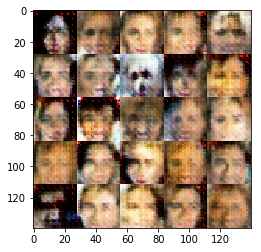

Epoch 1/1... Batch 1010... Discriminator Loss: 0.8230... Generator Loss: 1.1268
Epoch 1/1... Batch 1020... Discriminator Loss: 1.6850... Generator Loss: 0.6738
Epoch 1/1... Batch 1030... Discriminator Loss: 1.2914... Generator Loss: 0.5728
Epoch 1/1... Batch 1040... Discriminator Loss: 1.4355... Generator Loss: 1.6784
Epoch 1/1... Batch 1050... Discriminator Loss: 0.8413... Generator Loss: 1.3635
Epoch 1/1... Batch 1060... Discriminator Loss: 0.9316... Generator Loss: 3.6089
Epoch 1/1... Batch 1070... Discriminator Loss: 0.9176... Generator Loss: 1.4965
Epoch 1/1... Batch 1080... Discriminator Loss: 0.6915... Generator Loss: 1.4386
Epoch 1/1... Batch 1090... Discriminator Loss: 1.1844... Generator Loss: 0.6762
Epoch 1/1... Batch 1100... Discriminator Loss: 0.8185... Generator Loss: 1.1021


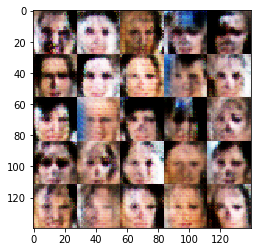

Epoch 1/1... Batch 1110... Discriminator Loss: 0.7665... Generator Loss: 1.3045
Epoch 1/1... Batch 1120... Discriminator Loss: 0.9362... Generator Loss: 1.2695
Epoch 1/1... Batch 1130... Discriminator Loss: 0.7549... Generator Loss: 1.7262
Epoch 1/1... Batch 1140... Discriminator Loss: 0.8440... Generator Loss: 2.0088
Epoch 1/1... Batch 1150... Discriminator Loss: 1.0422... Generator Loss: 1.6216
Epoch 1/1... Batch 1160... Discriminator Loss: 0.7122... Generator Loss: 1.4612
Epoch 1/1... Batch 1170... Discriminator Loss: 1.6058... Generator Loss: 0.7994
Epoch 1/1... Batch 1180... Discriminator Loss: 1.3149... Generator Loss: 0.6506
Epoch 1/1... Batch 1190... Discriminator Loss: 1.0155... Generator Loss: 0.9593
Epoch 1/1... Batch 1200... Discriminator Loss: 1.5125... Generator Loss: 0.4489


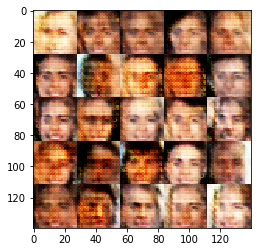

Epoch 1/1... Batch 1210... Discriminator Loss: 1.2352... Generator Loss: 1.3896
Epoch 1/1... Batch 1220... Discriminator Loss: 0.8517... Generator Loss: 1.3634
Epoch 1/1... Batch 1230... Discriminator Loss: 1.0852... Generator Loss: 0.9812
Epoch 1/1... Batch 1240... Discriminator Loss: 1.2642... Generator Loss: 2.2571
Epoch 1/1... Batch 1250... Discriminator Loss: 1.0829... Generator Loss: 1.2044
Epoch 1/1... Batch 1260... Discriminator Loss: 1.3821... Generator Loss: 2.3709
Epoch 1/1... Batch 1270... Discriminator Loss: 1.0625... Generator Loss: 0.7884
Epoch 1/1... Batch 1280... Discriminator Loss: 1.0815... Generator Loss: 1.2446
Epoch 1/1... Batch 1290... Discriminator Loss: 0.7243... Generator Loss: 1.4064
Epoch 1/1... Batch 1300... Discriminator Loss: 0.9320... Generator Loss: 1.3171


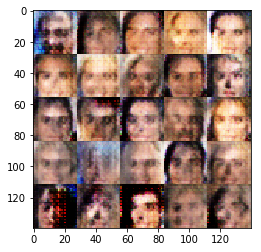

Epoch 1/1... Batch 1310... Discriminator Loss: 1.1432... Generator Loss: 0.8067
Epoch 1/1... Batch 1320... Discriminator Loss: 1.2200... Generator Loss: 0.8974
Epoch 1/1... Batch 1330... Discriminator Loss: 0.9881... Generator Loss: 1.2194
Epoch 1/1... Batch 1340... Discriminator Loss: 0.8686... Generator Loss: 1.2104
Epoch 1/1... Batch 1350... Discriminator Loss: 0.9857... Generator Loss: 1.0688
Epoch 1/1... Batch 1360... Discriminator Loss: 1.0446... Generator Loss: 1.1941
Epoch 1/1... Batch 1370... Discriminator Loss: 1.0268... Generator Loss: 1.0171
Epoch 1/1... Batch 1380... Discriminator Loss: 0.9600... Generator Loss: 1.0972
Epoch 1/1... Batch 1390... Discriminator Loss: 1.1013... Generator Loss: 1.1318
Epoch 1/1... Batch 1400... Discriminator Loss: 0.9816... Generator Loss: 1.6415


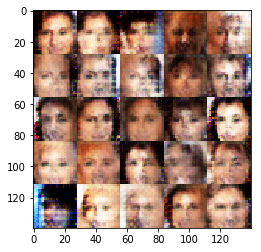

Epoch 1/1... Batch 1410... Discriminator Loss: 1.1003... Generator Loss: 1.0149
Epoch 1/1... Batch 1420... Discriminator Loss: 1.9201... Generator Loss: 0.3033
Epoch 1/1... Batch 1430... Discriminator Loss: 1.1651... Generator Loss: 1.0528
Epoch 1/1... Batch 1440... Discriminator Loss: 1.1455... Generator Loss: 2.2060
Epoch 1/1... Batch 1450... Discriminator Loss: 1.3858... Generator Loss: 0.6582
Epoch 1/1... Batch 1460... Discriminator Loss: 0.9598... Generator Loss: 1.3145
Epoch 1/1... Batch 1470... Discriminator Loss: 1.5455... Generator Loss: 0.6175
Epoch 1/1... Batch 1480... Discriminator Loss: 1.3281... Generator Loss: 2.0906
Epoch 1/1... Batch 1490... Discriminator Loss: 0.9634... Generator Loss: 1.1187
Epoch 1/1... Batch 1500... Discriminator Loss: 1.3934... Generator Loss: 0.6293


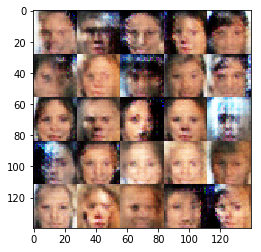

Epoch 1/1... Batch 1510... Discriminator Loss: 1.0055... Generator Loss: 1.0950
Epoch 1/1... Batch 1520... Discriminator Loss: 0.9613... Generator Loss: 1.3270
Epoch 1/1... Batch 1530... Discriminator Loss: 1.1290... Generator Loss: 0.7754
Epoch 1/1... Batch 1540... Discriminator Loss: 1.0590... Generator Loss: 0.9519
Epoch 1/1... Batch 1550... Discriminator Loss: 0.7842... Generator Loss: 1.6458
Epoch 1/1... Batch 1560... Discriminator Loss: 1.0334... Generator Loss: 0.9283
Epoch 1/1... Batch 1570... Discriminator Loss: 0.9765... Generator Loss: 1.0739
Epoch 1/1... Batch 1580... Discriminator Loss: 1.1115... Generator Loss: 0.9379
Epoch 1/1... Batch 1590... Discriminator Loss: 1.0302... Generator Loss: 1.0509
Epoch 1/1... Batch 1600... Discriminator Loss: 1.1031... Generator Loss: 0.7605


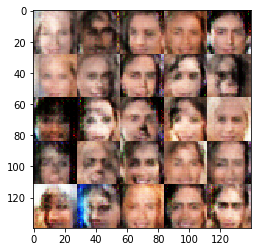

Epoch 1/1... Batch 1610... Discriminator Loss: 1.1225... Generator Loss: 1.2958
Epoch 1/1... Batch 1620... Discriminator Loss: 0.8820... Generator Loss: 1.0478
Epoch 1/1... Batch 1630... Discriminator Loss: 1.0226... Generator Loss: 0.8864
Epoch 1/1... Batch 1640... Discriminator Loss: 1.0566... Generator Loss: 1.2235
Epoch 1/1... Batch 1650... Discriminator Loss: 1.0798... Generator Loss: 1.1737
Epoch 1/1... Batch 1660... Discriminator Loss: 0.9758... Generator Loss: 0.8858
Epoch 1/1... Batch 1670... Discriminator Loss: 1.0531... Generator Loss: 0.8802
Epoch 1/1... Batch 1680... Discriminator Loss: 1.0462... Generator Loss: 0.8868
Epoch 1/1... Batch 1690... Discriminator Loss: 1.2213... Generator Loss: 0.7235
Epoch 1/1... Batch 1700... Discriminator Loss: 0.8127... Generator Loss: 1.2239


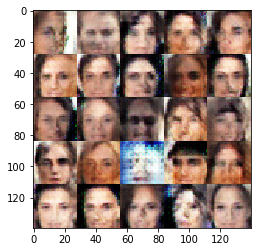

Epoch 1/1... Batch 1710... Discriminator Loss: 1.0696... Generator Loss: 0.7678
Epoch 1/1... Batch 1720... Discriminator Loss: 1.1980... Generator Loss: 1.0947
Epoch 1/1... Batch 1730... Discriminator Loss: 1.1529... Generator Loss: 1.2859
Epoch 1/1... Batch 1740... Discriminator Loss: 1.2227... Generator Loss: 0.9611
Epoch 1/1... Batch 1750... Discriminator Loss: 1.1662... Generator Loss: 1.1978
Epoch 1/1... Batch 1760... Discriminator Loss: 1.0851... Generator Loss: 0.8904
Epoch 1/1... Batch 1770... Discriminator Loss: 0.9613... Generator Loss: 1.0158
Epoch 1/1... Batch 1780... Discriminator Loss: 1.1463... Generator Loss: 1.1106
Epoch 1/1... Batch 1790... Discriminator Loss: 0.9388... Generator Loss: 1.4034
Epoch 1/1... Batch 1800... Discriminator Loss: 1.0249... Generator Loss: 1.2620


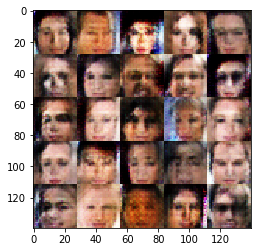

Epoch 1/1... Batch 1810... Discriminator Loss: 0.9686... Generator Loss: 1.1181
Epoch 1/1... Batch 1820... Discriminator Loss: 0.8840... Generator Loss: 1.4268
Epoch 1/1... Batch 1830... Discriminator Loss: 0.8854... Generator Loss: 1.4279
Epoch 1/1... Batch 1840... Discriminator Loss: 1.1966... Generator Loss: 2.4194
Epoch 1/1... Batch 1850... Discriminator Loss: 1.0585... Generator Loss: 1.3949
Epoch 1/1... Batch 1860... Discriminator Loss: 1.0157... Generator Loss: 0.8616
Epoch 1/1... Batch 1870... Discriminator Loss: 1.0943... Generator Loss: 0.7937
Epoch 1/1... Batch 1880... Discriminator Loss: 1.0826... Generator Loss: 0.8940
Epoch 1/1... Batch 1890... Discriminator Loss: 1.0049... Generator Loss: 1.1787
Epoch 1/1... Batch 1900... Discriminator Loss: 1.3006... Generator Loss: 0.6036


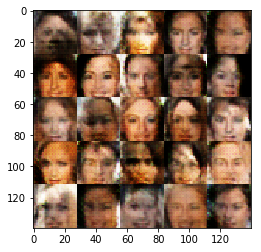

Epoch 1/1... Batch 1910... Discriminator Loss: 0.9385... Generator Loss: 1.3084
Epoch 1/1... Batch 1920... Discriminator Loss: 1.2743... Generator Loss: 2.3338
Epoch 1/1... Batch 1930... Discriminator Loss: 1.2064... Generator Loss: 1.6385
Epoch 1/1... Batch 1940... Discriminator Loss: 1.0975... Generator Loss: 1.7348
Epoch 1/1... Batch 1950... Discriminator Loss: 1.3629... Generator Loss: 0.6705
Epoch 1/1... Batch 1960... Discriminator Loss: 1.1338... Generator Loss: 1.7419
Epoch 1/1... Batch 1970... Discriminator Loss: 1.1436... Generator Loss: 1.4443
Epoch 1/1... Batch 1980... Discriminator Loss: 1.0737... Generator Loss: 0.8813
Epoch 1/1... Batch 1990... Discriminator Loss: 1.0556... Generator Loss: 1.1709
Epoch 1/1... Batch 2000... Discriminator Loss: 1.2776... Generator Loss: 1.6250


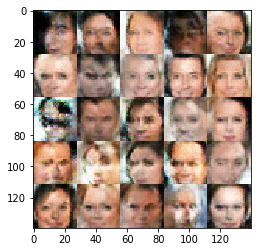

Epoch 1/1... Batch 2010... Discriminator Loss: 1.1850... Generator Loss: 0.6714
Epoch 1/1... Batch 2020... Discriminator Loss: 1.0065... Generator Loss: 1.2284
Epoch 1/1... Batch 2030... Discriminator Loss: 1.2006... Generator Loss: 0.7732
Epoch 1/1... Batch 2040... Discriminator Loss: 1.1949... Generator Loss: 0.6379
Epoch 1/1... Batch 2050... Discriminator Loss: 1.2199... Generator Loss: 0.9156
Epoch 1/1... Batch 2060... Discriminator Loss: 1.1103... Generator Loss: 1.1469
Epoch 1/1... Batch 2070... Discriminator Loss: 1.0142... Generator Loss: 1.4128
Epoch 1/1... Batch 2080... Discriminator Loss: 1.7017... Generator Loss: 0.3804
Epoch 1/1... Batch 2090... Discriminator Loss: 1.2716... Generator Loss: 0.8053
Epoch 1/1... Batch 2100... Discriminator Loss: 0.9498... Generator Loss: 1.0565


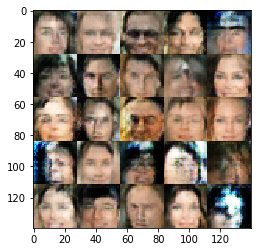

Epoch 1/1... Batch 2110... Discriminator Loss: 1.0597... Generator Loss: 1.0990
Epoch 1/1... Batch 2120... Discriminator Loss: 1.2087... Generator Loss: 0.7354
Epoch 1/1... Batch 2130... Discriminator Loss: 1.1103... Generator Loss: 1.1538
Epoch 1/1... Batch 2140... Discriminator Loss: 1.4911... Generator Loss: 2.3007
Epoch 1/1... Batch 2150... Discriminator Loss: 1.0350... Generator Loss: 0.9324
Epoch 1/1... Batch 2160... Discriminator Loss: 1.0914... Generator Loss: 0.7871
Epoch 1/1... Batch 2170... Discriminator Loss: 1.2587... Generator Loss: 0.6526
Epoch 1/1... Batch 2180... Discriminator Loss: 0.9267... Generator Loss: 1.0237
Epoch 1/1... Batch 2190... Discriminator Loss: 0.9480... Generator Loss: 0.8922
Epoch 1/1... Batch 2200... Discriminator Loss: 1.1542... Generator Loss: 0.8113


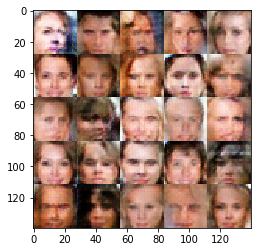

Epoch 1/1... Batch 2210... Discriminator Loss: 1.4904... Generator Loss: 2.4098
Epoch 1/1... Batch 2220... Discriminator Loss: 1.5883... Generator Loss: 1.7265
Epoch 1/1... Batch 2230... Discriminator Loss: 0.9293... Generator Loss: 1.0684
Epoch 1/1... Batch 2240... Discriminator Loss: 1.2100... Generator Loss: 0.7705
Epoch 1/1... Batch 2250... Discriminator Loss: 0.9088... Generator Loss: 1.0528
Epoch 1/1... Batch 2260... Discriminator Loss: 1.0108... Generator Loss: 0.9948
Epoch 1/1... Batch 2270... Discriminator Loss: 1.2969... Generator Loss: 0.6859
Epoch 1/1... Batch 2280... Discriminator Loss: 1.2571... Generator Loss: 1.0793
Epoch 1/1... Batch 2290... Discriminator Loss: 1.1736... Generator Loss: 1.0859
Epoch 1/1... Batch 2300... Discriminator Loss: 1.2469... Generator Loss: 0.6241


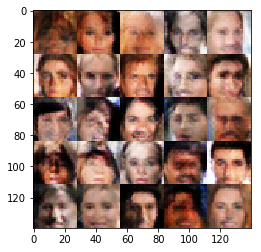

Epoch 1/1... Batch 2310... Discriminator Loss: 1.0545... Generator Loss: 0.9743
Epoch 1/1... Batch 2320... Discriminator Loss: 1.3396... Generator Loss: 0.8031
Epoch 1/1... Batch 2330... Discriminator Loss: 1.1341... Generator Loss: 1.1523
Epoch 1/1... Batch 2340... Discriminator Loss: 1.0298... Generator Loss: 1.1613
Epoch 1/1... Batch 2350... Discriminator Loss: 0.9667... Generator Loss: 1.4502
Epoch 1/1... Batch 2360... Discriminator Loss: 1.0510... Generator Loss: 1.7448
Epoch 1/1... Batch 2370... Discriminator Loss: 1.2629... Generator Loss: 0.7233
Epoch 1/1... Batch 2380... Discriminator Loss: 1.9292... Generator Loss: 0.3006
Epoch 1/1... Batch 2390... Discriminator Loss: 0.9992... Generator Loss: 1.6021
Epoch 1/1... Batch 2400... Discriminator Loss: 1.0242... Generator Loss: 0.9492


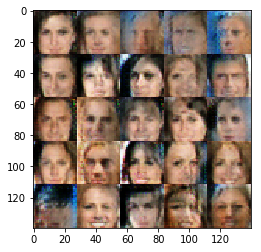

Epoch 1/1... Batch 2410... Discriminator Loss: 1.3008... Generator Loss: 0.8442
Epoch 1/1... Batch 2420... Discriminator Loss: 1.0729... Generator Loss: 0.8292
Epoch 1/1... Batch 2430... Discriminator Loss: 1.0058... Generator Loss: 0.9327
Epoch 1/1... Batch 2440... Discriminator Loss: 1.1348... Generator Loss: 1.0782
Epoch 1/1... Batch 2450... Discriminator Loss: 1.0431... Generator Loss: 0.9755
Epoch 1/1... Batch 2460... Discriminator Loss: 0.8614... Generator Loss: 1.0236
Epoch 1/1... Batch 2470... Discriminator Loss: 1.1280... Generator Loss: 1.3035
Epoch 1/1... Batch 2480... Discriminator Loss: 1.0859... Generator Loss: 0.9160
Epoch 1/1... Batch 2490... Discriminator Loss: 1.3254... Generator Loss: 0.8369
Epoch 1/1... Batch 2500... Discriminator Loss: 1.1785... Generator Loss: 1.0597


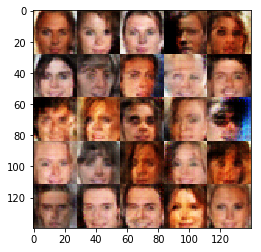

Epoch 1/1... Batch 2510... Discriminator Loss: 1.0126... Generator Loss: 1.1431
Epoch 1/1... Batch 2520... Discriminator Loss: 0.9544... Generator Loss: 1.2299
Epoch 1/1... Batch 2530... Discriminator Loss: 1.3020... Generator Loss: 0.9561
Epoch 1/1... Batch 2540... Discriminator Loss: 1.2047... Generator Loss: 0.9757
Epoch 1/1... Batch 2550... Discriminator Loss: 1.2458... Generator Loss: 1.0792
Epoch 1/1... Batch 2560... Discriminator Loss: 1.0102... Generator Loss: 1.1411
Epoch 1/1... Batch 2570... Discriminator Loss: 0.9907... Generator Loss: 1.4359
Epoch 1/1... Batch 2580... Discriminator Loss: 1.2143... Generator Loss: 0.7393
Epoch 1/1... Batch 2590... Discriminator Loss: 1.1105... Generator Loss: 1.3140
Epoch 1/1... Batch 2600... Discriminator Loss: 1.1077... Generator Loss: 1.0721


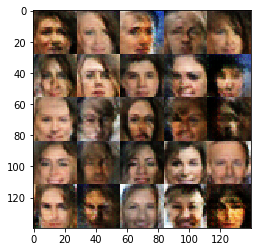

Epoch 1/1... Batch 2610... Discriminator Loss: 1.3372... Generator Loss: 0.6541
Epoch 1/1... Batch 2620... Discriminator Loss: 0.9872... Generator Loss: 0.8852
Epoch 1/1... Batch 2630... Discriminator Loss: 1.0546... Generator Loss: 1.2511
Epoch 1/1... Batch 2640... Discriminator Loss: 0.8519... Generator Loss: 1.1715
Epoch 1/1... Batch 2650... Discriminator Loss: 1.8360... Generator Loss: 0.3374
Epoch 1/1... Batch 2660... Discriminator Loss: 1.6073... Generator Loss: 0.4209
Epoch 1/1... Batch 2670... Discriminator Loss: 1.0255... Generator Loss: 1.0685
Epoch 1/1... Batch 2680... Discriminator Loss: 0.9237... Generator Loss: 0.9278
Epoch 1/1... Batch 2690... Discriminator Loss: 1.3534... Generator Loss: 1.7039
Epoch 1/1... Batch 2700... Discriminator Loss: 1.3014... Generator Loss: 0.6798


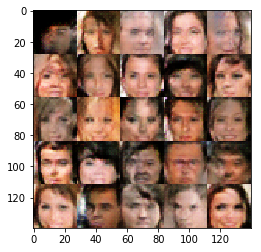

Epoch 1/1... Batch 2710... Discriminator Loss: 1.0819... Generator Loss: 1.0158
Epoch 1/1... Batch 2720... Discriminator Loss: 1.0358... Generator Loss: 1.1246
Epoch 1/1... Batch 2730... Discriminator Loss: 1.0729... Generator Loss: 0.7830
Epoch 1/1... Batch 2740... Discriminator Loss: 1.2562... Generator Loss: 1.0853
Epoch 1/1... Batch 2750... Discriminator Loss: 1.1034... Generator Loss: 0.9170
Epoch 1/1... Batch 2760... Discriminator Loss: 1.2201... Generator Loss: 1.0215
Epoch 1/1... Batch 2770... Discriminator Loss: 1.2616... Generator Loss: 1.3762
Epoch 1/1... Batch 2780... Discriminator Loss: 1.0802... Generator Loss: 0.8258
Epoch 1/1... Batch 2790... Discriminator Loss: 1.0750... Generator Loss: 1.0787
Epoch 1/1... Batch 2800... Discriminator Loss: 1.0947... Generator Loss: 0.8408


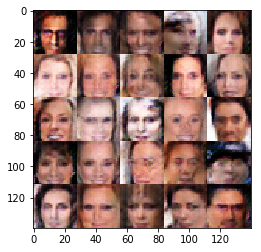

Epoch 1/1... Batch 2810... Discriminator Loss: 1.0830... Generator Loss: 1.3014
Epoch 1/1... Batch 2820... Discriminator Loss: 1.1545... Generator Loss: 0.7900
Epoch 1/1... Batch 2830... Discriminator Loss: 1.2092... Generator Loss: 0.8050
Epoch 1/1... Batch 2840... Discriminator Loss: 1.3113... Generator Loss: 0.7000
Epoch 1/1... Batch 2850... Discriminator Loss: 1.1282... Generator Loss: 0.7141
Epoch 1/1... Batch 2860... Discriminator Loss: 1.3067... Generator Loss: 1.0114
Epoch 1/1... Batch 2870... Discriminator Loss: 1.2328... Generator Loss: 1.4308
Epoch 1/1... Batch 2880... Discriminator Loss: 1.2464... Generator Loss: 0.9683
Epoch 1/1... Batch 2890... Discriminator Loss: 1.4168... Generator Loss: 0.7459
Epoch 1/1... Batch 2900... Discriminator Loss: 1.0290... Generator Loss: 0.9099


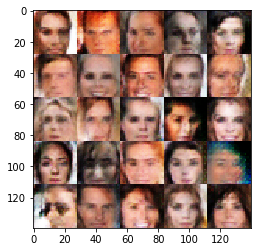

Epoch 1/1... Batch 2910... Discriminator Loss: 1.2039... Generator Loss: 0.7703
Epoch 1/1... Batch 2920... Discriminator Loss: 1.0987... Generator Loss: 1.2322
Epoch 1/1... Batch 2930... Discriminator Loss: 1.1120... Generator Loss: 0.7525
Epoch 1/1... Batch 2940... Discriminator Loss: 1.2084... Generator Loss: 0.6753
Epoch 1/1... Batch 2950... Discriminator Loss: 1.1915... Generator Loss: 1.4229
Epoch 1/1... Batch 2960... Discriminator Loss: 1.2286... Generator Loss: 0.9310
Epoch 1/1... Batch 2970... Discriminator Loss: 1.4635... Generator Loss: 0.5214
Epoch 1/1... Batch 2980... Discriminator Loss: 1.3385... Generator Loss: 1.1613
Epoch 1/1... Batch 2990... Discriminator Loss: 1.1703... Generator Loss: 0.7616
Epoch 1/1... Batch 3000... Discriminator Loss: 0.9915... Generator Loss: 1.2174


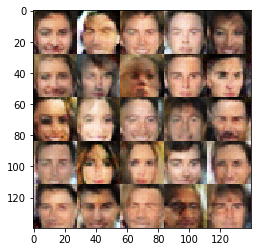

Epoch 1/1... Batch 3010... Discriminator Loss: 1.2335... Generator Loss: 1.0710
Epoch 1/1... Batch 3020... Discriminator Loss: 1.0549... Generator Loss: 0.9818
Epoch 1/1... Batch 3030... Discriminator Loss: 1.1896... Generator Loss: 1.0633
Epoch 1/1... Batch 3040... Discriminator Loss: 1.2588... Generator Loss: 0.8389
Epoch 1/1... Batch 3050... Discriminator Loss: 1.0417... Generator Loss: 1.0629
Epoch 1/1... Batch 3060... Discriminator Loss: 1.1387... Generator Loss: 0.8718
Epoch 1/1... Batch 3070... Discriminator Loss: 0.9346... Generator Loss: 0.9725
Epoch 1/1... Batch 3080... Discriminator Loss: 1.0682... Generator Loss: 0.9806
Epoch 1/1... Batch 3090... Discriminator Loss: 1.1774... Generator Loss: 1.4686
Epoch 1/1... Batch 3100... Discriminator Loss: 1.2729... Generator Loss: 0.7125


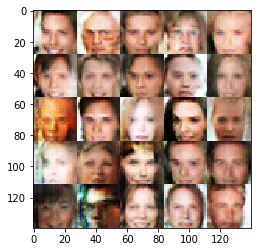

Epoch 1/1... Batch 3110... Discriminator Loss: 1.0533... Generator Loss: 0.8589
Epoch 1/1... Batch 3120... Discriminator Loss: 1.1361... Generator Loss: 1.0299
Epoch 1/1... Batch 3130... Discriminator Loss: 1.0781... Generator Loss: 1.0855
Epoch 1/1... Batch 3140... Discriminator Loss: 1.2991... Generator Loss: 0.7708
Epoch 1/1... Batch 3150... Discriminator Loss: 1.2181... Generator Loss: 0.7395
Epoch 1/1... Batch 3160... Discriminator Loss: 1.2822... Generator Loss: 1.0863


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.